<a href="https://colab.research.google.com/github/Krocata613020188-1/Project/blob/main/testview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
import torch
import numpy as np
import json
if torch.__version__=='1.6.0+cu101' and sys.platform.startswith('linux'):
    !pip install pytorch3d
else:
    need_pytorch3d=False
    try:
        import pytorch3d
    except ModuleNotFoundError:
        need_pytorch3d=True
    if need_pytorch3d:
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   118  100   118    0     0    634      0 --:--:-- --:--:-- --:--:--   634
100  404k    0  404k    0     0   737k      0 --:--:-- --:--:-- --:--:--     0
  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision stable) to /tmp/pip-req-build-2zu_jiw1
  Running command git clone -q https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-2zu_jiw1
  Running command git checkout -q 3fc3ea507bfbf7e1c2d5023a6db202698206f91d
     |████████████████████████████████| 49 kB 2.9 MB/s 
     |████████████████████████████████| 596 kB 14.6 MB/s 
  Created wheel for pytorch3d: filename=pytorch3d-0.6.1-cp37-cp37m-linux_x86_64.whl size=30319869 sha256=4b6c14bf2ceec9475c7144d522a2956e6a630e9c1ff2d83728e195142871ad9a
  Stored in directory: /tmp/pip-ephem-wheel-cache-kc1n4yas/wheels/4c/03/f0/326bb241eb86a155a12f217c81e16

In [2]:
!pip install utils

In [3]:
import matplotlib.pyplot as plt
from skimage.io import imread
from utils import *

# Util function for loading meshes
from pytorch3d.io import load_obj

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    FoVOrthographicCameras, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    TexturesVertex,
    TexturesAtlas,
    PointsRenderer,
    PointsRasterizationSettings,
    PointsRasterizer
)

In [4]:
# Set our device:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

In [5]:
!pip install Params

In [ ]:
obj_filename1 =  "/content/drive/MyDrive/pytorch3d-renderer-main/data/capsule/capsule.obj"

In [32]:
obj_filename2 =  "/content/drive/MyDrive/pytorch3d-renderer-main/data/ID4_2.obj"

In [ ]:
obj_filename1

In [ ]:
params = ({
"image_size": 256,
"camera_dist": 3,   
"elevation": 0,
"azim_angle": 0,
"obj_filename": "/content/drive/MyDrive/pytorch3d-renderer-main/data/capsule/capsule.obj"
})

In [ ]:
obj_filename

{'azim_angle': 0,
 'camera_dist': 3,
 'elevation': 0,
 'image_size': 256,
 'obj_filename': '/content/drive/MyDrive/pytorch3d-renderer-main/data/capsule/capsule.obj'}

In [33]:
# Get vertices, faces, and auxiliary information:
verts, faces, aux = load_obj(
    obj_filename2,
    device=device,
    load_textures=True,
    create_texture_atlas=True,
    texture_atlas_size=4,
    texture_wrap="repeat"
     )

# Create a textures object
atlas = aux.texture_atlas

# Initialize the mesh with vertices, faces, and textures.
# Created Meshes object
capsule_mesh = Meshes(
    verts=[verts],
    faces=[faces.verts_idx],
    textures=TexturesAtlas(atlas=[atlas]),)

/usr/local/lib/python3.7/dist-packages/pytorch3d/io/obj_io.py:533: UserWarning: Mtl file does not exist: /content/drive/MyDrive/pytorch3d-renderer-main/data/ID4_2.mtl
  warnings.warn(f"Mtl file does not exist: {f}")


In [34]:
print('We have {0} vertices and {1} faces.'.format(verts.shape[0], faces.verts_idx.shape[0]))

We have 65202 vertices and 97849 faces.


In [35]:
# Initialize the camera with camera distance, elevation, and azimuth angle
R, T = look_at_view_transform(dist = 0, elev = 
                              0, azim = 0) 
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# Here we set the output image to be of size 256 x 256 based on config.json 
raster_settings = RasterizationSettings(
    image_size = 1024, 
    blur_radius = 0.0, 
    faces_per_pixel = 1, 
)

# Initialize rasterizer by using a MeshRasterizer class
rasterizer = MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    )

In [36]:
# The textured phong shader interpolates the texture uv coordinates for 
# each vertex, and samples from a texture image.
shader = SoftPhongShader(device = device, cameras = cameras)

# Create a mesh renderer by composing a rasterizer and a shader
renderer = MeshRenderer(rasterizer, shader)

In [ ]:
# Render Meshes object
image = renderer(capsule_mesh)
# Plot rendered image
plt.figure(figsize=(10, 10))
plt.imshow(image[0, ..., :3].cpu().numpy())
plt.grid("off");
plt.axis("off");

/usr/local/lib/python3.7/dist-packages/pytorch3d/transforms/transform3d.py:782: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)


RuntimeError: ignored

In [ ]:
# The batch size represents the number of different viewpoints from which we 
# want to render the mesh.
batch_size = 4

# Create a batch of meshes by repeating the capsule mesh and associated textures. 
# Meshes has a useful `extend` method which allows us do this very easily. 
meshes = capsule_mesh.extend(batch_size)

# Get a batch of viewing angles. 
elev = torch.linspace(0, 360, batch_size)
azim = torch.linspace(-180, 180, batch_size)

# All the cameras helper methods support mixed type inputs and broadcasting. So we can 
# view the camera from the same distance and then specify elevation and azimuth angles 
# for each viewpoint as tensors. 
R, T = look_at_view_transform(dist = 3, elev = elev, azim = 0)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

In [ ]:
# We can pass arbirary keyword arguments to the rasterizer/shader via the renderer
# so the renderer does not need to be reinitialized if any of the settings change.
images = renderer(meshes, cameras=cameras)

In [ ]:
len(images)

4

In [ ]:
images[1]

tensor([[[1.0000, 1.0000, 1.0000, 0.0000],
         [1.0000, 1.0000, 1.0000, 0.0000],
         [1.0000, 1.0000, 1.0000, 0.0000],
         ...,
         [1.0000, 1.0000, 1.0000, 0.0000],
         [1.0000, 1.0000, 1.0000, 0.0000],
         [1.0000, 1.0000, 1.0000, 0.0000]],

        [[1.0000, 1.0000, 1.0000, 0.0000],
         [1.0000, 1.0000, 1.0000, 0.0000],
         [1.0000, 1.0000, 1.0000, 0.0000],
         ...,
         [1.0000, 1.0000, 1.0000, 0.0000],
         [1.0000, 1.0000, 1.0000, 0.0000],
         [1.0000, 1.0000, 1.0000, 0.0000]],

        [[1.0000, 1.0000, 1.0000, 0.0000],
         [1.0000, 1.0000, 1.0000, 0.0000],
         [1.0000, 1.0000, 1.0000, 0.0000],
         ...,
         [1.0000, 1.0000, 1.0000, 0.0000],
         [1.0000, 1.0000, 1.0000, 0.0000],
         [1.0000, 1.0000, 1.0000, 0.0000]],

        ...,

        [[0.5000, 0.5000, 0.5000, 0.5001],
         [0.5000, 0.5000, 0.5000, 0.5013],
         [0.5000, 0.5000, 0.5000, 0.5037],
         ...,
         [1.0000, 1.0

In [ ]:
type(images[0])

torch.Tensor

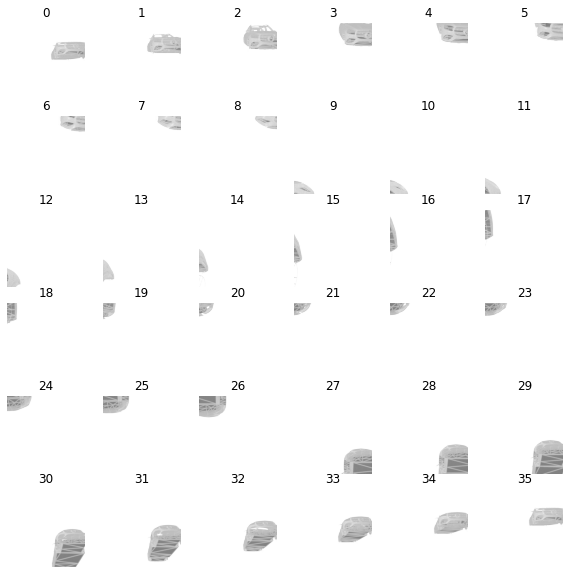

In [ ]:
#1
plt.figure(figsize=(10, 10))
for i in list(range(36)) :
  plt.subplot(6,6,i+1)
  plt.imshow(images[i].cpu().numpy())
  plt.grid("off");
  plt.axis("off");
  plt.title(i)
plt.show()

In [ ]:
# The batch size represents the number of different viewpoints from which we 
# want to render the mesh.
batch_size = 36

# Create a batch of meshes by repeating the capsule mesh and associated textures. 
# Meshes has a useful `extend` method which allows us do this very easily. 
meshes = capsule_mesh.extend(batch_size)

# Get a batch of viewing angles. 
elev = torch.linspace(0, 360, batch_size)
azim = torch.linspace(-180, 180, batch_size)

# All the cameras helper methods support mixed type inputs and broadcasting. So we can 
# view the camera from the same distance and then specify elevation and azimuth angles 
# for each viewpoint as tensors. 
R, T = look_at_view_transform(dist = 5, elev = elev, azim = 0)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)
# We can pass arbirary keyword arguments to the rasterizer/shader via the renderer
# so the renderer does not need to be reinitialized if any of the settings change.
images = renderer(meshes, cameras=cameras)

RuntimeError: ignored

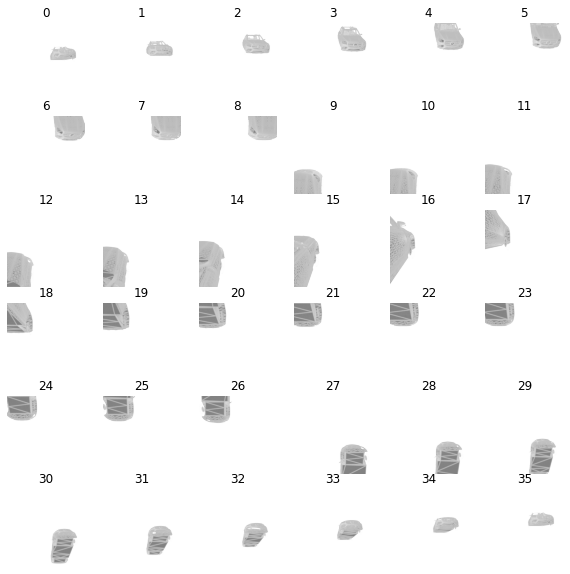

In [ ]:
#2
plt.figure(figsize=(10, 10))
for i in list(range(36)) :
  plt.subplot(6,6,i+1)
  plt.imshow(images[i].cpu().numpy())
  plt.grid("off");
  plt.axis("off");
  plt.title(i)
plt.show()

In [ ]:
# The batch size represents the number of different viewpoints from which we 
# want to render the mesh.
batch_size = 6

# Create a batch of meshes by repeating the capsule mesh and associated textures. 
# Meshes has a useful `extend` method which allows us do this very easily. 
meshes = capsule_mesh.extend(batch_size)

# Get a batch of viewing angles. 
elev = torch.linspace(0, 360, batch_size)
azim = torch.linspace(-180, 180, batch_size)

# All the cameras helper methods support mixed type inputs and broadcasting. So we can 
# view the camera from the same distance and then specify elevation and azimuth angles 
# for each viewpoint as tensors. 
R, T = look_at_view_transform(dist = 6, elev = elev, azim = 0)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)
# We can pass arbirary keyword arguments to the rasterizer/shader via the renderer
# so the renderer does not need to be reinitialized if any of the settings change.
images = renderer(meshes, cameras=cameras)

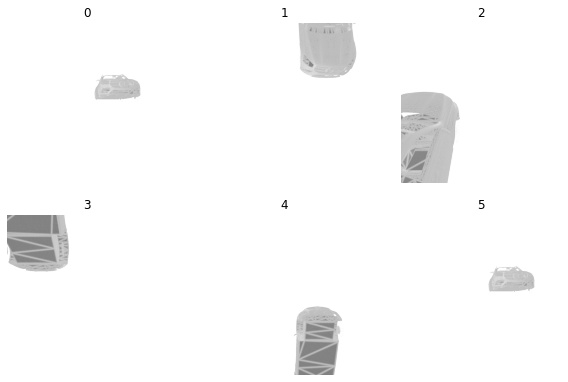

In [ ]:
plt.figure(figsize=(10, 10))
for i in list(range(6)) :
  plt.subplot(3,3,i+1)
  plt.imshow(images[i].cpu().numpy())
  plt.grid("off");
  plt.axis("off");
  plt.title(i)
plt.show()

In [ ]:
im1 = images[0]

In [ ]:
im1.shape

torch.Size([1024, 1024, 4])

In [ ]:
im1save = im1.cpu().numpy()

In [ ]:
im1save

array([[[1., 1., 1., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 0.],
        ...,
        [1., 1., 1., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 0.]],

       [[1., 1., 1., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 0.],
        ...,
        [1., 1., 1., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 0.]],

       [[1., 1., 1., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 0.],
        ...,
        [1., 1., 1., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 0.]],

       ...,

       [[1., 1., 1., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 0.],
        ...,
        [1., 1., 1., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 0.]],

       [[1., 1., 1., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 0.],
        ...,
        [1., 1., 1., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 0.]],

       [[1., 1., 1., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 0.],
        ...,
        [1., 1., 1., 0.],
        [1., 1.

In [ ]:
type(im1save)

numpy.ndarray

In [ ]:
im1save.shape

(1024, 1024, 4)

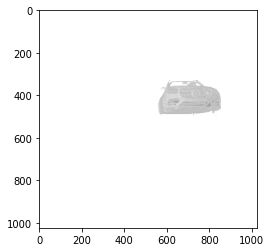

In [ ]:
plt.imshow(im1save)

In [ ]:
from torchvision.utils import save_image
import torch
import torchvision


In [ ]:
from PIL import Image 
import PIL 

In [ ]:
images.shape

torch.Size([6, 1024, 1024, 4])

In [ ]:

save_image(im1, 'img1.png')

TypeError: ignored

In [ ]:
im1save.save("ima1.jpg")

AttributeError: ignored

In [ ]:
save_image(im1save, 'img1.png')

TypeError: ignored

In [ ]:
from torchvision.utils import save_image
import torch
import torchvision

rand_tensor= torch.rand(64, 3,28,28) 

img1 = rand_tensor[0]
# img1 = img1.numpy() # TypeError: tensor or list of tensors expected, got <class 'numpy.ndarray'>
save_image(img1, 'img1.png')

In [ ]:
save_image(make_grid(postprocess_image(1024, 1024, 4), nrow=8),"XXX.jpg")` 

In [ ]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [ ]:
ims1 = tensor_to_image(im1save)

In [ ]:
ims1.save('/content/drive/MyDrive/project/images_car/im2.png')

In [ ]:
ims1.save('/content/drive/MyDrive/project/images_car','im1.png')

KeyError: ignored

In [ ]:
range(len(images))

range(0, 6)

In [ ]:
ims = []

In [ ]:
save = []

In [ ]:
for i in range(len(images)) :
 ims =  tensor_to_image(images[i].cpu().numpy())
 save.append(ims)

In [ ]:
len(save)

6

In [ ]:
save[2].save('/content/drive/MyDrive/project/images_car',"images.png")

KeyError: ignored

In [ ]:
ims2 = tensor_to_image(,images[1].cpu().numpy())

TypeError: ignored

In [ ]:
for i in range(len(save)) :
  save[i].save("/content/drive/MyDrive/project/images_car/images"+str(i)+".png")

In [47]:
# The batch size represents the number of different viewpoints from which we 
# want to render the mesh.
batch_size = 6

# Create a batch of meshes by repeating the capsule mesh and associated textures. 
# Meshes has a useful `extend` method which allows us do this very easily. 
meshes = capsule_mesh.extend(batch_size)

# Get a batch of viewing angles. 
elev = torch.linspace(0, 360, batch_size)
azim = torch.linspace(0, 360, batch_size)

# All the cameras helper methods support mixed type inputs and broadcasting. So we can 
# view the camera from the same distance and then specify elevation and azimuth angles 
# for each viewpoint as tensors. 
R, T = look_at_view_transform(dist = 100, elev = 0, azim = azim)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)
# We can pass arbirary keyword arguments to the rasterizer/shader via the renderer
# so the renderer does not need to be reinitialized if any of the settings change.
images = renderer(meshes, cameras=cameras)

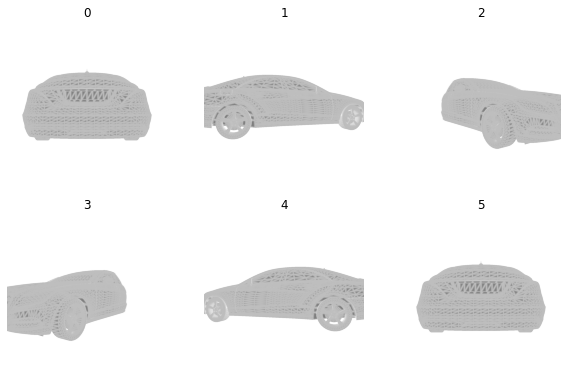

In [48]:
plt.figure(figsize=(10, 10))
for i in list(range(6)) :
  plt.subplot(3,3,i+1)
  plt.imshow(images[i].cpu().numpy())
  plt.grid("off");
  plt.axis("off");
  plt.title(i)
plt.show()

In [25]:
!pip install bpy

ERROR: Could not find a version that satisfies the requirement bpy (from versions: 0.0.0a0, 2.82.1, 2.91a0)
ERROR: No matching distribution found for bpy


In [28]:
import bpy


ModuleNotFoundError: ignored

In [27]:
import bpy

# get the current object
current_obj = obj_filename2

# get the scene
scene = bpy.context.scene

# set geometry to origin
bpy.ops.object.origin_set(type="GEOMETRY_ORIGIN")

zverts = []

# get all z coordinates of the vertices
for face in current_obj.data.polygons:
    verts_in_face = face.vertices[:]
    for vert in verts_in_face:
        local_point = current_obj.data.vertices[vert].co
        world_point = current_obj.matrix_world * local_point
        zverts.append(world_point[2])

# set the minimum z coordinate as z for cursor location
scene.cursor_location = (0, 0, min(zverts))

# set the origin to the cursor
bpy.ops.object.origin_set(type="ORIGIN_CURSOR")

# set the object to (0,0,0)
current_obj.location = (0,0,0)

# reset the cursor
scene.cursor_location = (0,0,0)

ModuleNotFoundError: ignored